In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import pymongo
import pickle
import bson
import subprocess

# Other external scripts
import lst1_mongodb_example
import utils

client_tcu  = pymongo.MongoClient("localhost:27017")
client_caco = pymongo.MongoClient("localhost:27018")

#### TCU properties:

In [2]:
# !python lst1_mongodb_example.py --list-available

#### CaCo databases and collections:

In [3]:
# client_caco = pymongo.MongoClient("localhost:27018")

# all_databases = np.sort(client_caco.list_database_names())

# print(f"--- {'':^40s} ---")
# print(f"--- {'Available CaCo databases and collections':^40s} ---")
# print(f"--- {'':^40s} ---")
# for database in all_databases:
#     print(f"\n--- {f'Database - {database}':^40s} ---")
    
#     all_collections = np.sort(client_caco[database].list_collection_names())
#     for i, collection in enumerate(all_collections):
#         print(f"{i:4d} : {collection}")

#### All properties from CaCo database:

In [4]:
# # Selecting CaCo database
# caco_db = client_caco.CACO

# dict_caco_names = {}
# all_collections = np.sort(caco_db.list_collection_names())
# for coll_name in all_collections:
#     coll = caco_db[coll_name]
#     if coll not in ["STATE", "RUN_INFORMATION"] and "week" in coll_name:
    
#         print(f"\n--- {f'Collection - {coll_name}':^40s} ---")
#         names = coll.distinct("name")
        
#         dict_caco_names[coll_name.replace("week", "min")] = names
#         for i,n in enumerate(names):
#             print(f"{i:4.0f} : {n}")

In [5]:
# %%time

# def get_records(mongo_client, database_name, collection_name, query):
#     collection = mongo_client[database_name][collection_name]
#     response   = collection.find(query)
#     records = tuple(doc for doc in response)    
#     return records
# query = None

# if read_db:
    
#     # Reading TCU database
#     print("Reading TCU database")
#     records_tcu  = get_records(client_tcu,  "lst1_obs_summary", "camera", query)

#     # Reading CaCo database
#     print("Reading CaCo database")
#     records_caco = get_records(client_caco, "CACO", "RUN_INFORMATION", query)  
    
#     # Saving the objects
#     with open("objects/records_tcu.pkl", "wb") as f:
#         pickle.dump(records_tcu, f, pickle.HIGHEST_PROTOCOL)
#     with open("objects/records_caco.pkl", "wb") as f:
#         pickle.dump(records_caco, f, pickle.HIGHEST_PROTOCOL)

# else:
    
#     # Reading the saved objects
#     with open("objects/records_tcu.pkl", "rb") as f:
#         records_tcu = pickle.load(f)
#     with open("objects/records_caco.pkl", "rb") as f:
#         records_caco = pickle.load(f)

In [6]:
dict_caco_states = {0 : "OFF", 1 : "DATA_MONITORING", 2 : "MONITORED", 3 : "SAFE", 4 : "STANDBY",
                    5 : "READY", 6 : "OBSERVING", 7 : "TPOINT", 8 : "UNDEFINED", 9 : "TRANSITIONAL", 10 : "ERROR"}
dict_caco_state_colors = {0 : "k", 1 : "darkviolet", 2 : "darkviolet", 3 : "lime", 4 : "gold",
                          5 : "c", 6 : "darkblue", 7 : "b", 8 : "r", 9 : "darkorange", 10 : "r"}

variable_tcu = "CameraControl_FSM_state"
tstart = datetime.fromisoformat("2024-02-25-00:00:00")
tstop  = datetime.fromisoformat("2024-04-01-00:00:00")


out_tcu = lst1_mongodb_example.get_entries(client_tcu, variable_tcu, astropy_time=False, tstart=tstart, tstop=tstop)
date_tcu, value_tcu = np.array(out_tcu["time"]), np.array(out_tcu["value"])

value_str_tcu = np.array([dict_caco_states[v] for v in value_tcu])

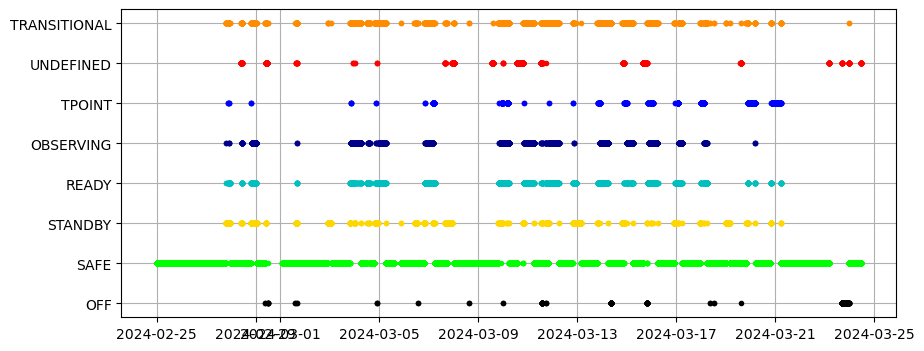

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
for key in dict_caco_states:
    mask_key = (value_tcu == key)
    ax.plot(date_tcu[mask_key], value_str_tcu[mask_key], marker=".", ls="", color=dict_caco_state_colors[key])
ax.grid()
plt.show()

#### Extracting the timespans of each state

In [8]:
# Creating a timespan dictionary for each key
timespans_dict = {}
for key in dict_caco_states.keys():
    timespans_dict[key] = {"tstart" : [], "tstop" : [], "tspan" : []}

before_state = value_tcu[0]
initial_time = date_tcu[0]
for i in range(len(value_tcu))[1:]:
    
    actual_state = value_tcu[i]

    if before_state != actual_state:
        final_time = date_tcu[i]

        timespans_dict[actual_state]["tstart"].append(initial_time)
        timespans_dict[actual_state]["tstop"].append(final_time)
        
        timespans_dict[actual_state]["tspan"].append((final_time - initial_time).total_seconds())

        initial_time = date_tcu[i]
        
    before_state = actual_state

#### Getting all TCU property names

In [9]:
string_properties = !python lst1_mongodb_example.py --list-available
all_tcu_properties = np.array([s.split(" : ")[-1] for s in string_properties[3:]])

camera_related_tcu_properties = []
non_camera_properties_prefix = ["AMC_", "AuxControl_", "CDM2_", "DriveControl_", "SecurityBrokerControl_"]

for p in all_tcu_properties:
    flag_camera = True
    for non_p in non_camera_properties_prefix:
        if non_p in p:
            flag_camera = False
            break
    if flag_camera:
        camera_related_tcu_properties.append(p)

print(f"There are {len(all_tcu_properties)} TCU properties in total")
print(f"There are {len(camera_related_tcu_properties)} TCU Camera-related properties in total")

There are 1159 TCU properties in total
There are 498 TCU Camera-related properties in total


In [ ]:
array = camera_related_tcu_properties[50:100]
for i, prop in enumerate(array):
    print(f"{i}/{len(array)}")
    # # Construct the SLURM command
    # output_file = "/fefs/aswg/workspace/juan.jimenez/access_tcu_caco_database/objects/output_slurm/slurm_job-%j.out"
    # slurm_command = f"sbatch -p short --wrap='python script_get_property_size.py {prop}'"
    
    # # Submit the job using subprocess
    # result = subprocess.run(slurm_command, shell=True, capture_output=True, text=True)
    
    # # Print the result to see if the submission was successful
    # print(result.stdout)
    # if result.stderr:
    #     print(f"Error: {result.stderr}")

    !python script_get_property_size.py $prop
    

0/50
Finding data of property CameraControl_RunUtils_is_test...
Extracting for state 1 : DATA_MONITORING
Extracting for state 2 : MONITORED
Extracting for state 3 : SAFE
Running over timespans... 0/56


#### **Here we are doing the trick of extracting the size of a chunk for each property of the TCU database**

In [ ]:
dict_tcu_property_bytes = {}
for p in camera_related_tcu_properties:
    dict_tcu_property_bytes[p] = 0
    
# Taking the main collections and chunks pointers
property_collection = client_tcu['bridgesmonitoring']['properties']
chunk_collection = client_tcu['bridgesmonitoring']['chunks']

for ip, _property in enumerate(camera_related_tcu_properties):
    
    descriptors = property_collection.find({'property_name': _property})

    for desc in descriptors:
        query = {'pid': desc['_id']}
        query.update({"begin": {"$gte": tstart}, "end": {"$lte": tstop}})

        chunks = chunk_collection.find(query)
        for chunk in chunks:

            bson_data = bson.BSON.encode(chunk)
            size_in_bytes = len(bson_data)

            dict_tcu_property_bytes[_property] = size_in_bytes
            
            break
    print(f"{ip/len(camera_related_tcu_properties)*100:2.3f}% Extracting bytes of {_property}")

#### Getting the number of entries for each state and timespan, so then the bytes

In [ ]:
%%time
# Creating a dictionary to store the information
event_dict = {}
for key in dict_caco_states.keys():
    event_dict[key] = np.repeat(0, len(timespans_dict[key]["tstart"]))

# Taking the main collections and chunks pointers
property_collection = client_tcu['bridgesmonitoring']['properties']
chunk_collection = client_tcu['bridgesmonitoring']['chunks']

for p, _property in enumerate(camera_related_tcu_properties):
    print(f"Finding data of property {_property}... {p}/{len(camera_related_tcu_properties)}") if p % 1 == 0 else None
    descriptors = property_collection.find({'property_name': _property})

    for desc in descriptors:
        for state in dict_caco_states.keys():
            print(f"Extracting for state {state} : {dict_caco_states[state]}")
            # print(f"The number of timespans is -> {len(timespans_dict[state]['tstart'])}")

            # Then running for all the timespans
            for i in range(len(timespans_dict[state]["tstart"]))[:]:

                _tstart = timespans_dict[state]["tstart"][i]
                _tstop  = timespans_dict[state]["tstop"][i]
                # _center_time = _tstart + (_tstop - _tstart) / 2
                # _timespan = (_tstop - _tstart).total_seconds()

                # print(f"From {_tstart} to {_tstop}, a total of {_timespan:.0f} seconds")
                print(f"Running over timespans... {i}/{len(timespans_dict[state]['tstart'])}") if i% 400 == 0 else None
                
                query = {'pid': desc['_id']}
                query.update({"begin": {"$gte": _tstart}, "end": {"$lte": _tstop}})

                number_chunks = chunk_collection.count_documents(query)

                # event_dict[state]['timestamp'].append(_center_time)
                event_dict[state][i] += number_chunks * dict_tcu_property_bytes[_property]

In [ ]:
# # Saving the object
# with open(f"objects/event_dict_state_{state}.pkl", "wb") as f:
#     pickle.dump(event_dict, f, pickle.HIGHEST_PROTOCOL)
    
# # Reading the saved objects
# with open(f"objects/event_dict_state_{state}.pkl", "rb") as f:
#     event_dict = pickle.load(f)